In [1]:
!git clone https://github.com/umutcankarakas/Fairness.git

Cloning into 'Fairness'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 203.20 KiB | 2.60 MiB/s, done.


In [2]:
from math import sqrt
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Loading Data and Analyzing

In [3]:
df = pd.read_csv('Fairness/cleaned_train')

In [4]:
df #i = "sex" aka sensitive feature, 8th index

,a,b,c,d,e,f,g,h,i,j,k,l,m,n
0,3,5,3,0,2,8,3,0,1,2,0,40,0,0
1,5,1,4,0,0,4,2,0,1,0,0,13,0,0
2,3,0,10,3,1,6,3,0,1,0,0,40,0,0
3,5,0,11,2,0,6,2,4,1,0,0,40,0,0
4,2,0,16,0,0,5,0,4,0,0,0,40,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,2,0,12,5,0,0,0,0,0,0,0,38,0,0
32557,4,0,7,3,0,7,2,0,1,0,0,40,0,1
32558,5,0,7,3,4,8,5,0,0,0,0,40,0,0
32559,2,0,10,3,2,8,1,0,1,0,0,20,0,0


In [5]:
df.agg(
    {
        "a": ["min", "max", "median", "mean"],
        "b": ["min", "max", "median", "mean"],
        "c": ["min", "max", "median", "mean"],
        "d": ["min", "max", "median", "mean"],
        "e": ["min", "max", "median", "mean"],
        "f": ["min", "max", "median", "mean"],
        "g": ["min", "max", "median", "mean"],
        "h": ["min", "max", "median", "mean"],
        "i": ["min", "max", "median", "mean"],
        "j": ["min", "max", "median", "mean"],
        "k": ["min", "max", "median", "mean"],
        "l": ["min", "max", "median", "mean"],
        "m": ["min", "max", "median", "mean"],
        "n": ["min", "max", "median", "mean"],
    }
)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n
min,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
max,9.000000,100.000000,74.000000,15.00000,6.000000,100.000000,5.000000,4.000000,1.000000,99.000000,43.000000,99.000000,100.000000,1.00000
median,3.000000,0.000000,8.000000,3.00000,1.000000,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,40.000000,0.000000,0.00000
mean,3.410553,6.334203,8.986978,3.40309,1.077485,10.127361,2.380854,0.459752,0.669205,1.042843,0.850127,40.437456,3.270876,0.24081


In [6]:
sqrt(9) * sqrt(101) * sqrt(76) * sqrt(16) * sqrt(7) * sqrt(101) * sqrt(6) * sqrt(5) * sqrt(2) * sqrt(100) * sqrt(44) * sqrt(99) * sqrt(101) 

1436278579.8281224

In [7]:
input_df = df.iloc[:, :-1]
output_df = df.iloc[:,-1:]

In [8]:
input_df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m
0,3,5,3,0,2,8,3,0,1,2,0,40,0
1,5,1,4,0,0,4,2,0,1,0,0,13,0
2,3,0,10,3,1,6,3,0,1,0,0,40,0
3,5,0,11,2,0,6,2,4,1,0,0,40,0
4,2,0,16,0,0,5,0,4,0,0,0,40,12


In [9]:
output_df.head()

,n
0,0
1,0
2,0
3,0
4,0


### Calculating Correlation Matrix

In [10]:
corr_mat = df.corr()

In [11]:
display(corr_mat)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n
a,1.000000,0.049541,-0.075308,0.113561,-0.215968,0.043092,0.127332,-0.028947,0.087623,0.074299,0.056813,0.068722,-0.011860,0.227666
b,0.049541,1.000000,-0.004521,0.023832,0.075694,0.988871,-0.043479,0.023072,-0.065777,-0.014750,-0.014358,-0.166775,-0.009258,-0.072804
c,-0.075308,-0.004521,1.000000,0.019802,0.024093,-0.002136,0.014840,0.097822,0.026840,0.000657,-0.010203,-0.018469,0.042601,-0.008813
d,0.113561,0.023832,0.019802,1.000000,-0.013268,0.023514,0.031089,0.009120,0.034275,0.019838,0.016962,0.009361,0.080450,0.009117
e,-0.215968,0.075694,0.024093,-0.013268,1.000000,0.080836,0.362819,0.131782,-0.380043,-0.073978,-0.066610,-0.221882,0.024567,-0.377794
f,0.043092,0.988871,-0.002136,0.023514,0.080836,1.000000,-0.043347,0.026629,-0.070318,-0.017243,-0.017708,-0.162957,-0.009740,-0.083713
g,0.127332,-0.043479,0.014840,0.031089,0.362819,-0.043347,1.000000,0.120530,-0.169737,-0.026857,-0.030770,0.056941,0.023813,-0.171771
h,-0.028947,0.023072,0.097822,0.009120,0.131782,0.026629,0.120530,1.000000,-0.117363,-0.019771,-0.023834,-0.054443,0.064256,-0.096839
i,0.087623,-0.065777,0.026840,0.034275,-0.380043,-0.070318,-0.169737,-0.117363,1.000000,0.048243,0.045415,0.229309,0.013384,0.215980
j,0.074299,-0.014750,0.000657,0.019838,-0.073978,-0.017243,-0.026857,-0.019771,0.048243,1.000000,-0.030914,0.078261,0.006098,0.222072


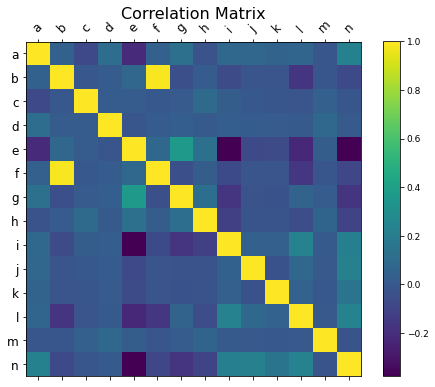

In [12]:
f = plt.figure(figsize=(8, 6))
plt.matshow(corr_mat, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix', fontsize=16);

### Training a Classifier Model

In [13]:
X = np.array(input_df)
Y = np.array(output_df)

In [14]:
model = DecisionTreeClassifier()
model.fit(X, Y)
cvs = cross_val_score(model, X, Y, scoring='accuracy')
print(cvs)
print(sum(cvs)/len(cvs))

[0.80776908 0.79652948 0.80052211 0.81418919 0.81802826]
0.8074076237998394


In [15]:
out = model.predict([X[1,:]])

In [16]:
out

array([0])

In [17]:
out[0]

0

### Calculating the Discrimination Percentage of The Model

In [18]:
trial_count = 1000
disc_count = 0
row_count = np.shape(X)[0]
indexes = random.sample(range(row_count), trial_count)

In [19]:
for index in indexes:
  original_prediction = model.predict([X[index,:]])
  row_data = np.copy(X[index,:])
  row_data[8] = np.absolute(row_data[8]-1)
  modified_prediction = model.predict([row_data])
  if(original_prediction != modified_prediction): 
    disc_count += 1



In [20]:
disc_count

69

In [21]:
disc_percentage = disc_count/trial_count * 100

In [22]:
disc_percentage

6.9